> Why do i have to restart all for the PDF to change?

# Setup & Utils

In [712]:
!pip install --quiet reportlab
!pip install --quiet matplotlib pandas


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [713]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak, ListFlowable, ListItem, PageTemplate
from reportlab.platypus.frames import Frame
from reportlab.lib import colors
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import letter, landscape, A4
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from IPython.display import display, clear_output
from functools import partial

import pandas as pd
import numpy as np
import os
import io
import textwrap

np.random.seed(42)

# Config

In [714]:
OUTPUT_PATH = "./output/Social_Media_Sentiment_Report.pdf"

NAVY = "#346699"
GRAY = "#808080"
MINT = "#61DDAA"
LIGHT_BLUE = '#BFDBFE'
LIGHT_RED = '#FF9E9E'
DARK_RED = "#E31A1A"
BLACK  = "#000000"
WHITE = "#FFFFFF"

# Get Data

In [715]:
# Hardcode dummy data
data = []
for _ in range(600):
	data.append([
		np.random.choice(pd.date_range("2026-01-01", periods=30)),
		np.random.choice(["twitter", "instagram", "youtube"]),
		np.random.choice(["positive", "neutral", "negative"], p=[0.55, 0.30, 0.15]),
		"Sample post content",
		"https://example.com/post",
		np.random.choice([f"trend_{i}" for i in range(1, 501)])
	])

df = pd.DataFrame(
	data,
	columns=["DATE", "SOURCE", "SENTIMENT", "POST", "LINK", "TREND"]
)

df.head()

,DATE,SOURCE,SENTIMENT,POST,LINK,TREND
0,2026-01-07,twitter,positive,Sample post content,https://example.com/post,trend_72
1,2026-01-29,twitter,positive,Sample post content,https://example.com/post,trend_467
2,2026-01-23,youtube,positive,Sample post content,https://example.com/post,trend_373
3,2026-01-04,youtube,positive,Sample post content,https://example.com/post,trend_258
4,2026-01-24,instagram,positive,Sample post content,https://example.com/post,trend_192


# Create Layout

In [716]:
doc = SimpleDocTemplate(
	OUTPUT_PATH,
    pagesize=landscape(A4),
    leftMargin=0,
    rightMargin=0,
    bottomMargin=0
)

page_width, page_height = doc.pagesize
width_in = page_width / 72
height_in = page_height / 72

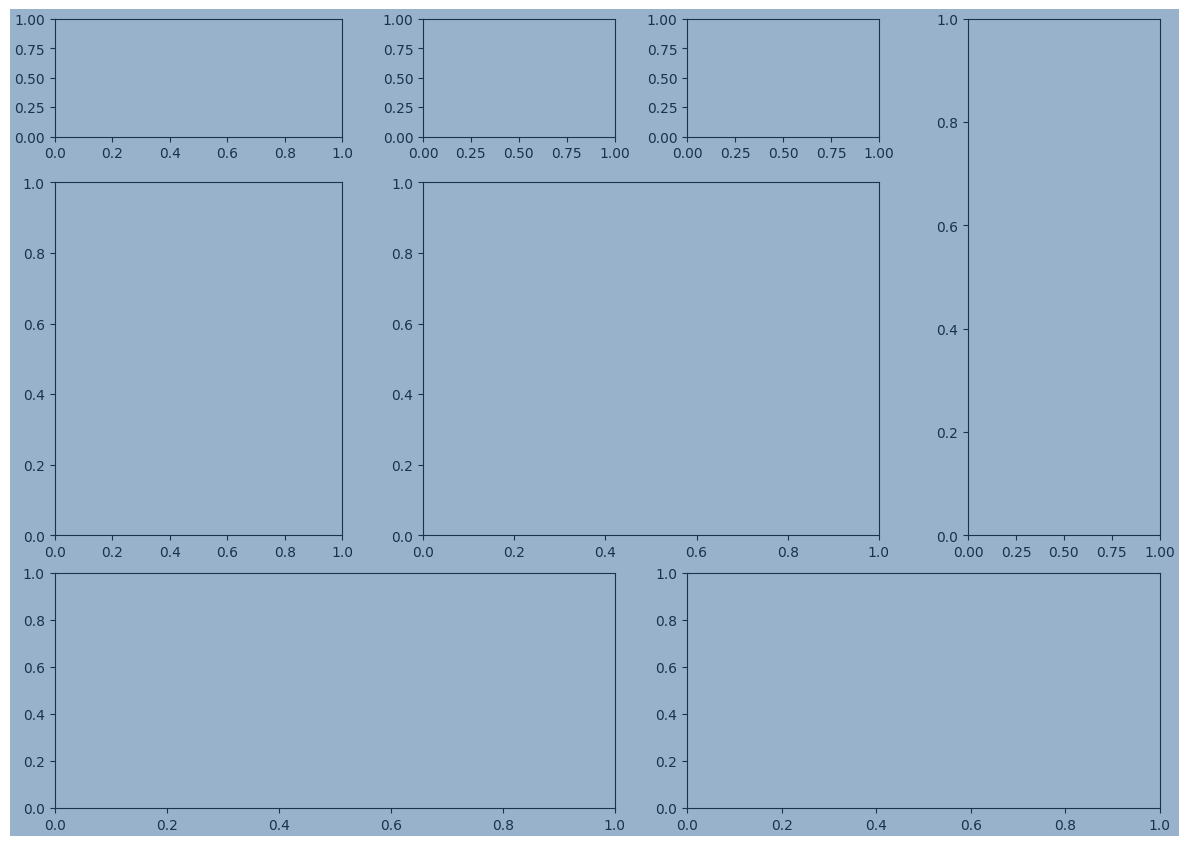

In [717]:
layout = [
    ["1", "2", "3", "6"],
    ["4", "5", "5", "6"],
    ["7", "7", "8", "8"],
]

master_fig, axs = plt.subplot_mosaic(
    layout,
    figsize=(width_in, height_in),  # A4
    gridspec_kw={
        "height_ratios": [1, 3, 2],
        "width_ratios": [1.5, 1, 1, 1]
    },
    constrained_layout=True
)

# @@@ debug
master_fig.patches.append(
    Rectangle(
        (0, 0), 1, 1,
        transform=master_fig.transFigure,  # <-- figure coordinates
        facecolor=NAVY,
        alpha=0.5,
        zorder=1000
    )
)

# plt.tight_layout(pad=2.0)

# Create Separate Elements

## Cards

In [718]:
def kpi_card(ax, value, value_color=NAVY, value_size=20, big_label=None, small_label=None):
	ax.clear()

	ax.axis('off')

	# Card background
	ax.add_patch(
		Rectangle(
			(0, 0), 1, 1,
			transform=ax.transAxes,
			facecolor=WHITE
		)
	)

	# Big Label
	if big_label:
		ax.set_title(
			big_label,
			loc="left",
			fontsize=12,
			fontweight="bold",
			color=NAVY,
			pad=5
		)

	# Small Label
	if small_label:
		ax.text(
			0.0, 0.85, 
			transform=ax.transAxes,
			s=small_label,
			fontsize=12,
			color=GRAY,
			ha='left', 
		)
	
	# Main value
	ax.text(
		0.0, 0.35,
		transform=ax.transAxes,
		s=value,
		ha='left', 
		va='center',
		fontsize=value_size,
		fontweight='bold',
		color=value_color
	)

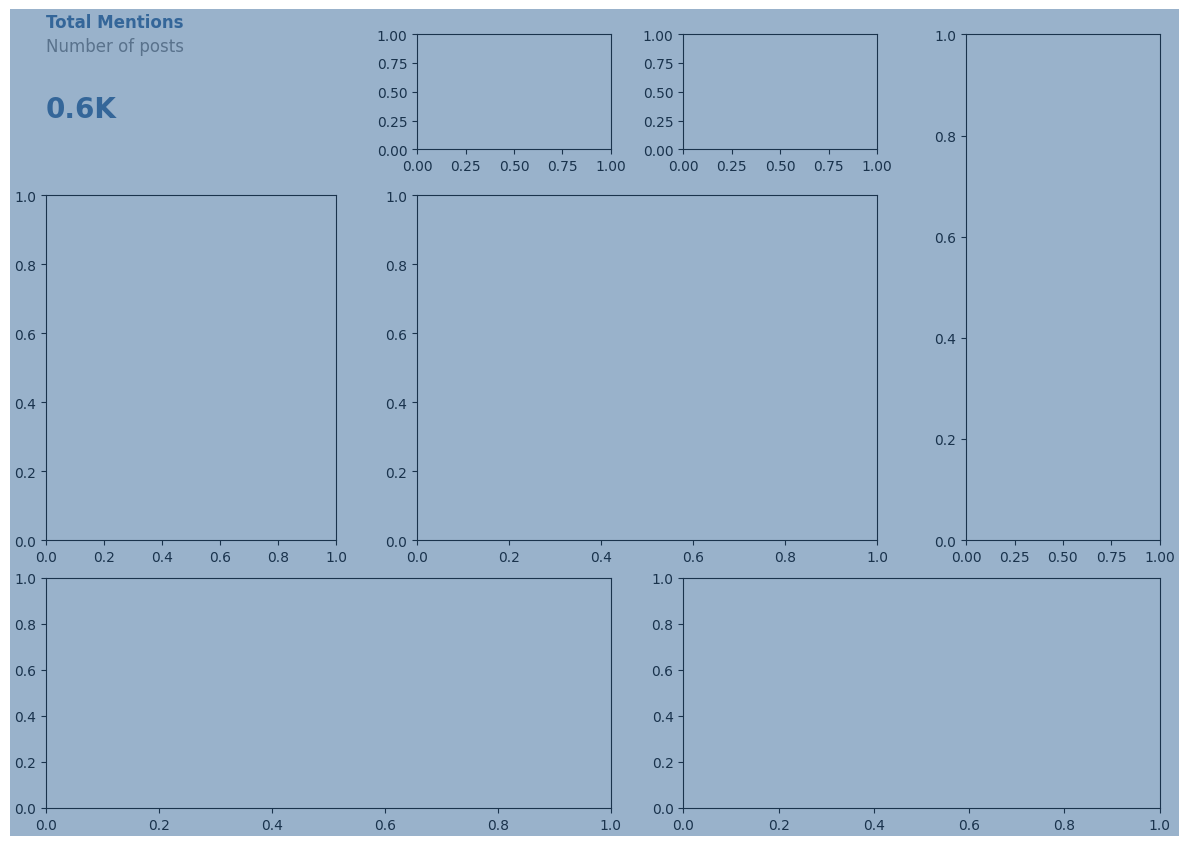

In [719]:
f = lambda x: f"{x/1000:.1f}K" if x % 1000 else f"{int(x/1000)}K"

total_mentions = str(f(len(df)))
kpi_card(axs["1"], total_mentions, big_label="Total Mentions", small_label="Number of posts")

clear_output(wait=True)
display(master_fig)


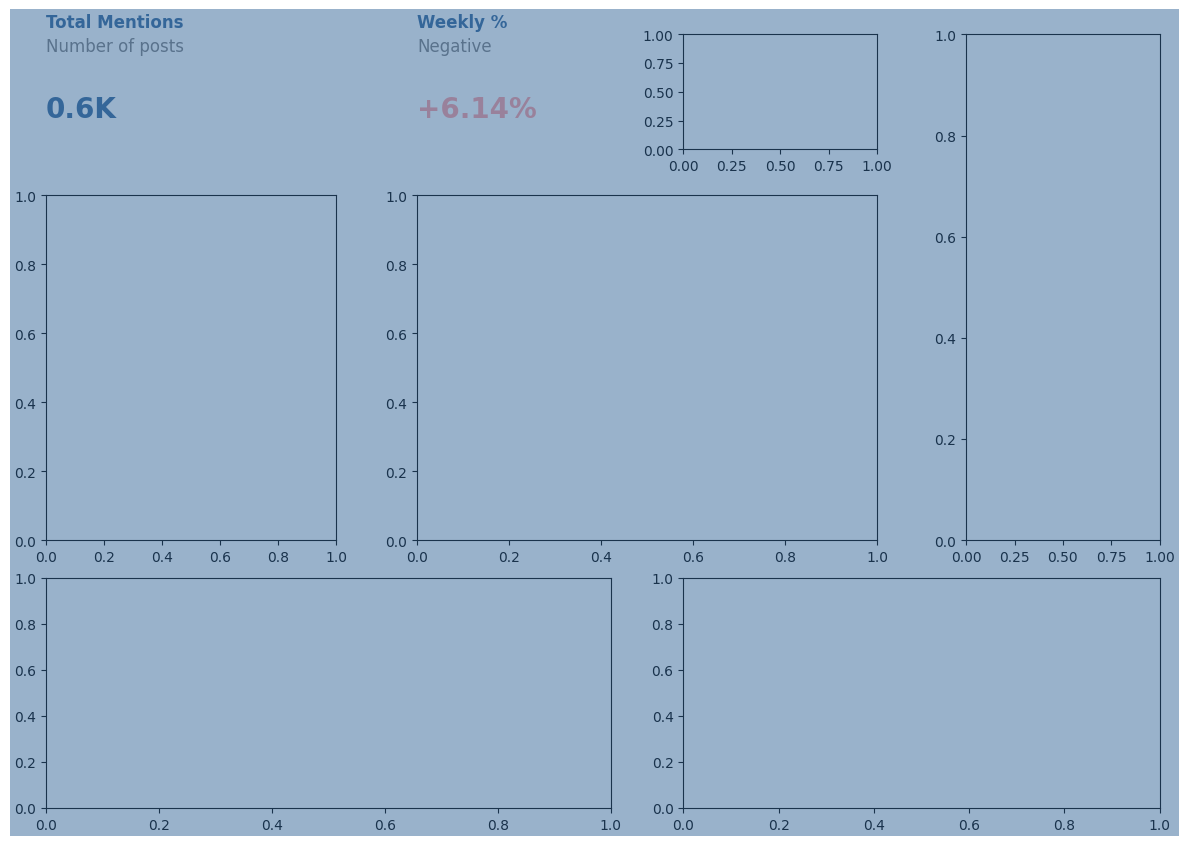

In [720]:
last_week_diff = (
    df.assign(YEAR_WEEK=df["DATE"].dt.strftime("%Y-%U"))
      .groupby("YEAR_WEEK")["SENTIMENT"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)["negative"]
      .mul(100)
      .diff()
      .iloc[-1]
)

if last_week_diff < 0:
    value_color = MINT
    last_week_diff_formatted = f"-{last_week_diff:.2f}%"
else:
    value_color = LIGHT_RED
    last_week_diff_formatted = f"+{last_week_diff:.2f}%"

kpi_card(axs["2"], last_week_diff_formatted, value_color=value_color, big_label="Weekly %", small_label="Negative")

clear_output(wait=True)
display(master_fig)

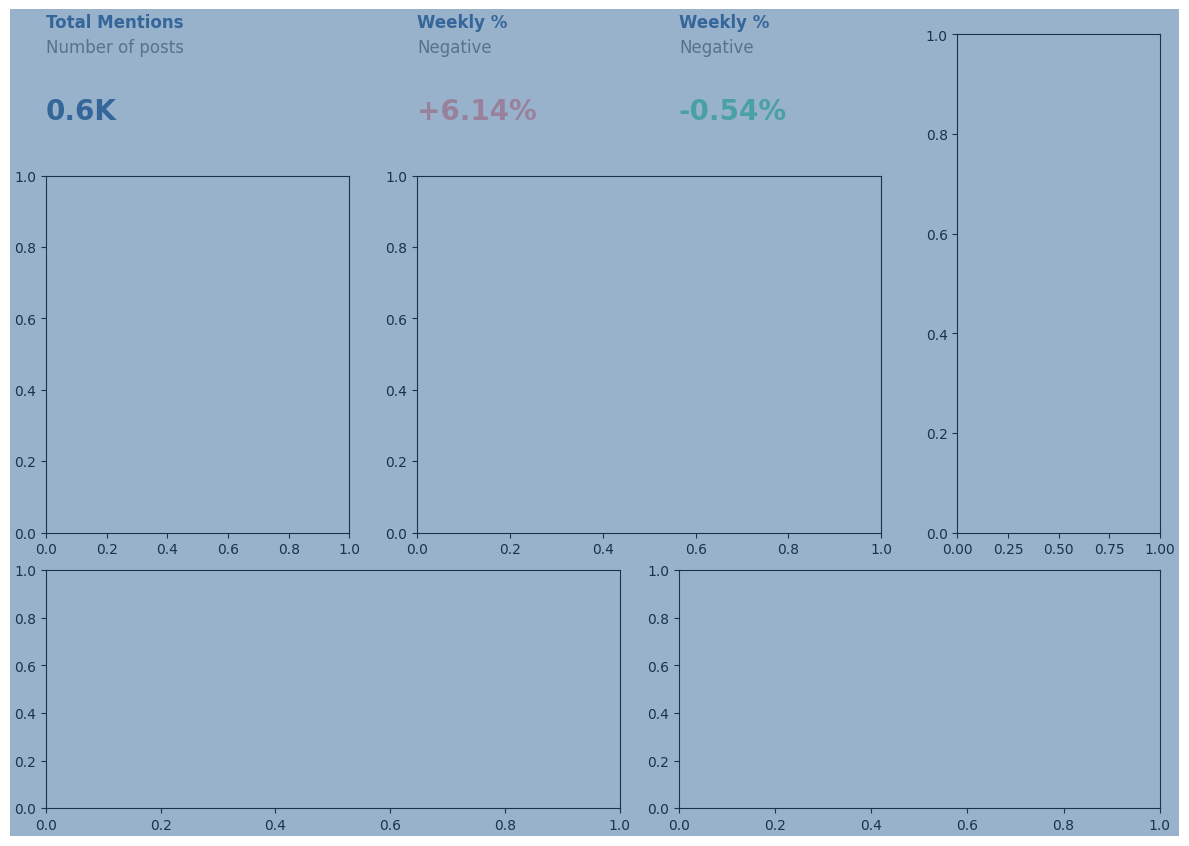

In [721]:
last_day_diff = (
    df
    .assign(DATE=pd.to_datetime(df["DATE"]))
    .groupby("DATE")["SENTIMENT"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)["negative"]
    .mul(100)
    .diff()
    .iloc[-1]
)

if last_day_diff < 0:
    value_color = MINT
    last_day_diff_formatted = f"{last_day_diff:.2f}%"
else:
    value_color = LIGHT_RED
    last_day_diff_formatted = f"+{last_day_diff:.2f}%"

kpi_card(axs["3"], last_day_diff_formatted, value_color=value_color, big_label="Weekly %", small_label="Negative")

clear_output(wait=True)
display(master_fig)

## "Sentiment Shared" Donut

In [722]:
def donut_chart_sentiment(ax, labels, portion):
	ax.clear()

	ax.axis('off')

	colors = [LIGHT_BLUE, MINT, LIGHT_RED]

	ax.set_title(
		"Sentiment Shared",
		loc="left",
		fontsize=12,
		fontweight="bold",
		color=NAVY,
		pad=20
	)

	# Pie chart
	wedges, _, _ = ax.pie(portion, radius=1.0, colors=colors,
			autopct='%1.2f%%', pctdistance=1,)

	# # Legend
	# ax.legend(wedges, labels,
	# 	loc="lower center",
	# 	ncol= len(labels),
	# 	bbox_to_anchor=(0.5, 0.0),
	# 	frameon=False
	# )

	# Draw donut hole
	centre_circle = Circle((0, 0), 0.5, fc='white')
	ax.add_artist(centre_circle)

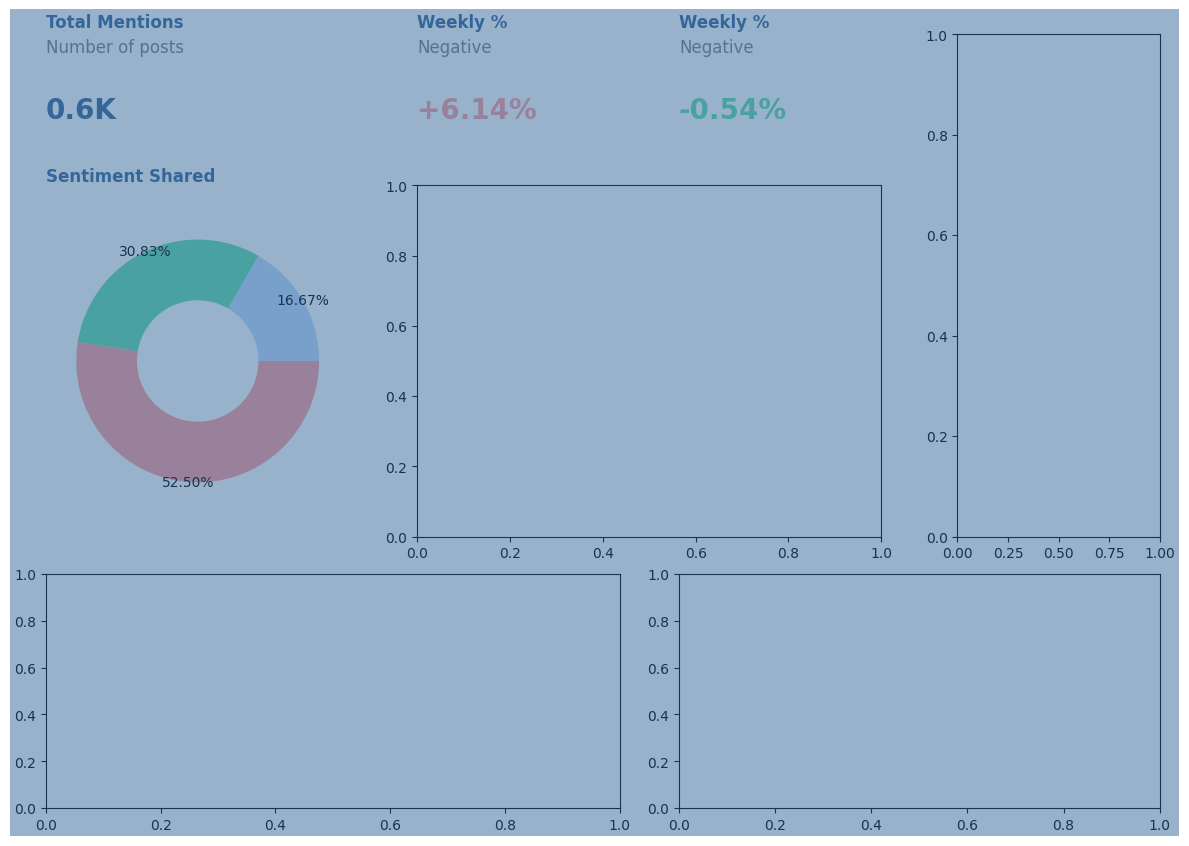

In [723]:
labels = ['Negative', 'Neutral', 'Positive']
counts = (
    df["SENTIMENT"]
    .str.capitalize()
    .value_counts()
    .reindex(labels, fill_value=0)
)

portion = counts.values.tolist()
donut_chart_sentiment(axs["4"], labels, portion)

clear_output(wait=True)
display(master_fig)

## "Daily Sentiment Movement" Line

In [724]:
def line_chart_daily_sentiment(ax, date, percentage_pos, percentage_neg):
	date = pd.to_datetime(date)

	ax.clear()

	ax.set_title(
		"Daily Sentiment Movement",
		loc="left",
		fontsize=12,
		fontweight="bold",
		color=NAVY,
		pad=10
	)

	# Lines
	ax.plot(date, percentage_pos, color=MINT, label='Positive %', linewidth=2)
	ax.plot(date, percentage_neg, color=LIGHT_RED, label='Negative %', linewidth=2)

	# # Legend
	# leg = ax.legend(
	# 	loc='lower center',
	# 	bbox_to_anchor=(0.4, 0.0),
	# 	ncol=2,
	# 	frameon=False
	# )
	# for line in leg.get_lines():
	# 	line.set_linewidth(6)

	# Axes
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['bottom'].set_visible(False)
	ax.spines['left'].set_visible(False)

	# # Ticks - Every 7D
	# ticks = pd.date_range(start=date.min(), end=date.max(), freq='7D')
	# ax.xaxis.set_major_locator(FixedLocator(mdates.date2num(ticks)))

	# Tick - First, middle, last
	tick_positions = [date.iloc[0], date.iloc[-1]]
	n = len(date)
	if n > 2:
		middle_index = n // 2
		tick_positions.insert(1, date[middle_index])
	ax.xaxis.set_major_locator(FixedLocator(mdates.date2num(tick_positions)))

	ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
	ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
	ax.tick_params(axis='both', length=0, colors=GRAY)

	ax.set_xlabel('Date')
	ax.set_ylabel('%')

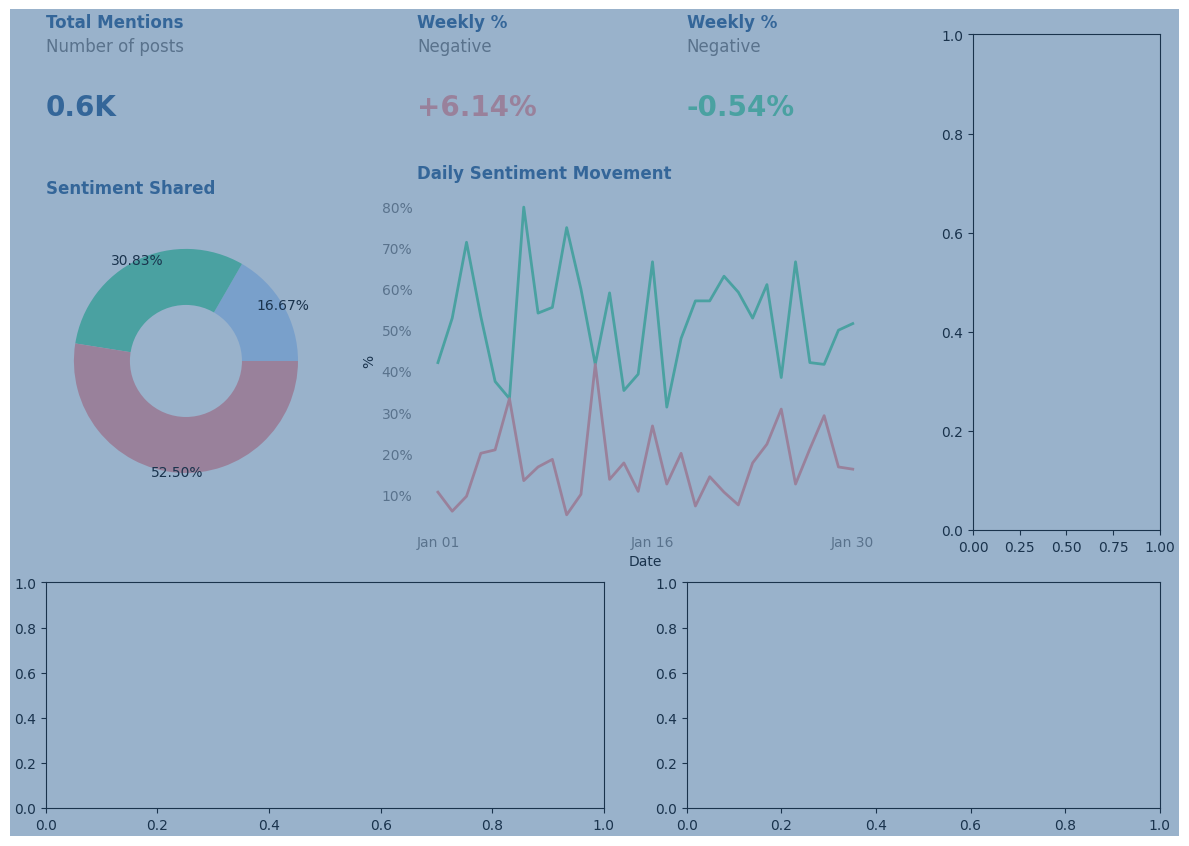

In [725]:
daily_pct = (
    df.groupby("DATE")["SENTIMENT"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
      .reindex(columns=["positive", "negative"], fill_value=0)
      .mul(100)
      .reset_index()
)

line_chart_daily_sentiment(axs["5"], daily_pct['DATE'], daily_pct['positive'], daily_pct['negative'])

clear_output(wait=True)
display(master_fig)

## "Platform Distribution" Stacked Bar

In [726]:
def stacked_bar_platform_dist(ax, labels, negative, neutral, positive):
	totals = np.array(negative) + np.array(neutral) + np.array(positive)
	order = np.argsort(totals)[::] 

	labels   = np.array(labels)[order]
	negative = np.array(negative)[order]
	neutral  = np.array(neutral)[order]
	positive = np.array(positive)[order]

	ax.clear()

	# ax.margins(x=0.1)

	ax.set_title(
		"Platform Distribution",
		loc="left",
		fontsize=12,
		fontweight="bold",
		color=NAVY,
		pad=5
	)

	# Stacked bars
	y = np.arange(len(labels)) 
	ax.barh(y, negative, color=LIGHT_RED, label='Negative')
	ax.barh(y, neutral, color=LIGHT_BLUE, left=np.array(negative), label='Neutral')
	ax.barh(y, positive, color=MINT, left=np.array(negative) + np.array(neutral),  label='Positive')

	# Axes
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['bottom'].set_visible(False)
	ax.spines['left'].set_visible(False)

	# Ticks
	ax.tick_params(axis='both', length=0, colors=NAVY)

	ax.set_yticks(y)
	ax.set_yticklabels(labels)

	max_total = totals.max()
	mid_total = max_total / 2
	ax.set_xlim(0, max_total)
	ax.set_xticks([0, mid_total, max_total])
	ax.xaxis.set_major_formatter(
		mticker.FuncFormatter(
			lambda x, _: (
				f"{int(x)}" if abs(x) < 1000
				else f"{x/1000:.1f}K" if x % 1000
				else f"{int(x/1000)}K"
			)
		)
	)

	ax.set_xlabel('Total')

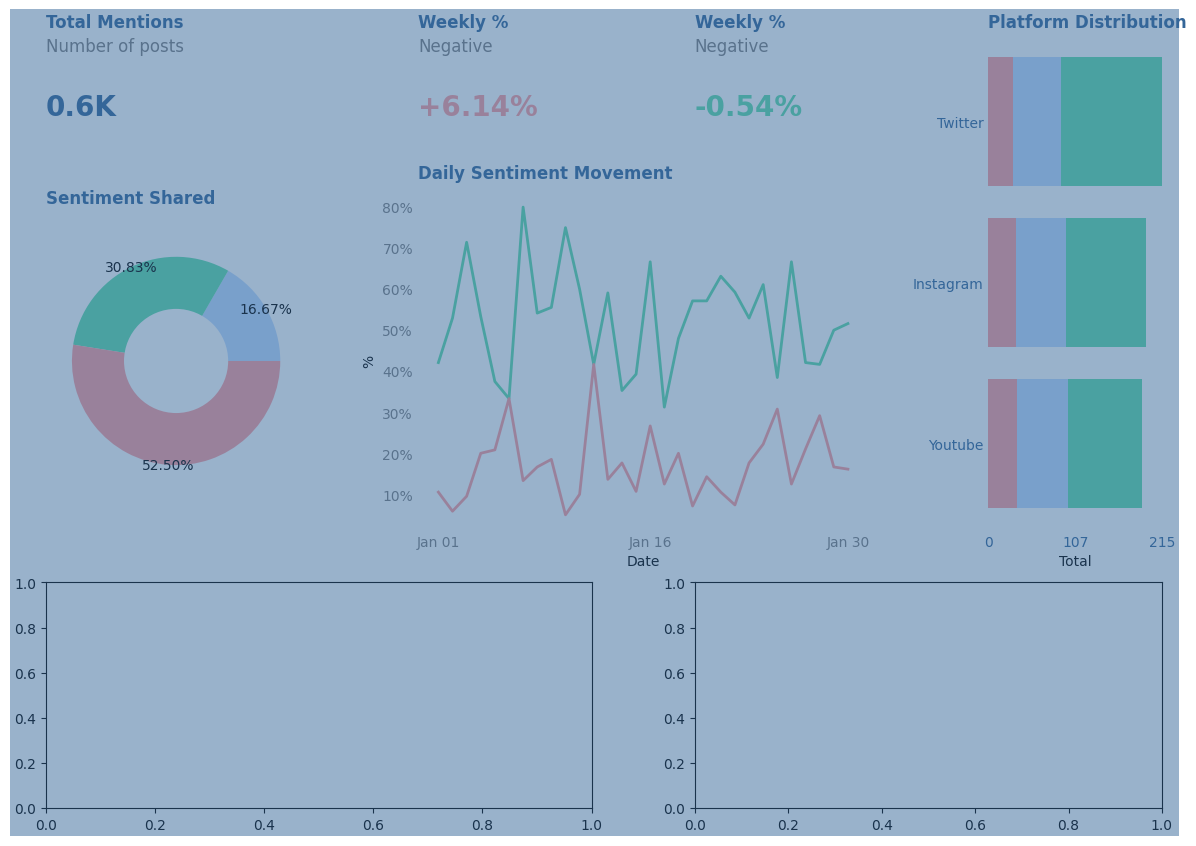

In [727]:
platform_dist = (
    df.groupby(["SOURCE", "SENTIMENT"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=["negative", "neutral", "positive"], fill_value=0)
)

stacked_bar_platform_dist(
    axs["6"],
    platform_dist.index.str.capitalize().tolist(), 
    platform_dist['negative'], 
    platform_dist['neutral'], 
    platform_dist['positive']
)

clear_output(wait=True)
display(master_fig)


## "Trend Analysis" Stacked Bar with Line

In [728]:
def stacked_bar_trend_analysis(ax, dates, negative, neutral, positive):
	dates = pd.to_datetime(dates)

	ax.clear()

	ax.set_title(
		"Trend Analysis",
		loc="left",
		fontsize=12,
		fontweight="bold",
		color=NAVY,
		pad=10
	)

	# Vertical stacked bar
	ax.bar(dates, negative, color=LIGHT_RED, label='Negative')
	ax.bar(dates, neutral, color=LIGHT_BLUE, bottom=negative, label='Neutral')
	ax.bar(dates, positive, color=MINT, bottom=np.array(negative) + np.array(neutral), label='Positive')

	# Line
	ax.plot(
		dates,
		negative,
		color='darkred',
		linewidth=2,
		linestyle='dashed',
		label='Negative Trend'
	)

	# Legend
	legend = ax.legend(
		loc='lower center',
		bbox_to_anchor=(0.5, -0.50),
		ncol=4,
		frameon=True
	)
	legend.get_frame().set_edgecolor("black")

	# Axes
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['bottom'].set_visible(False)
	ax.spines['left'].set_visible(False)

	# Ticks
	ax.tick_params(axis='both', length=0, colors=GRAY)

	ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

	ax.yaxis.set_major_formatter(
		mticker.FuncFormatter(
			lambda x, _: (
				f"{int(x)}" if abs(x) < 1000
				else f"{x/1000:.1f}K" if x % 1000
				else f"{int(x/1000)}K"
			)
		)
	)

	ax.set_xlabel('Date')
	ax.set_ylabel('Total')

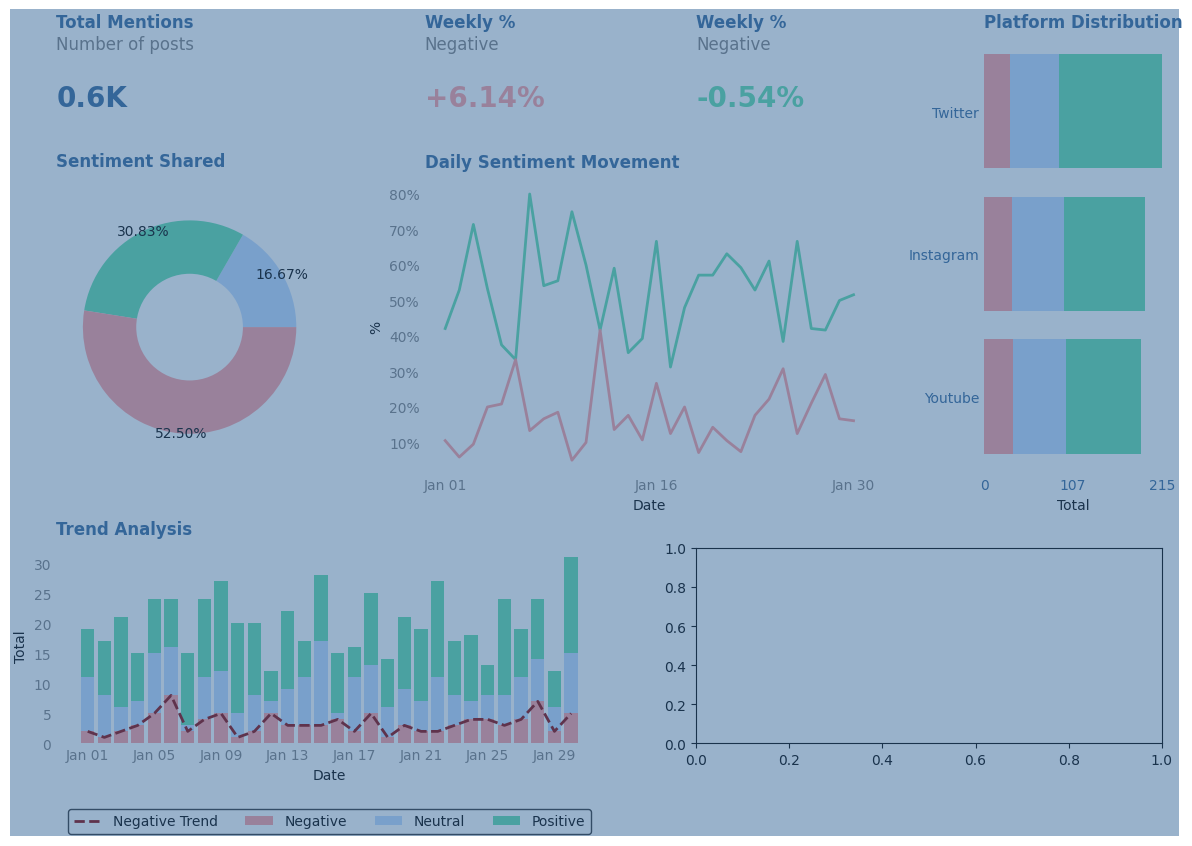

In [729]:
df["DATE"] = pd.to_datetime(df["DATE"])

trend_dist = (
    df.groupby(["DATE", "SENTIMENT"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=["negative", "neutral", "positive"], fill_value=0)
      .sort_index()
)

stacked_bar_trend_analysis(
    axs["7"],
    trend_dist.index.strftime("%Y-%m-%d").tolist(),
    trend_dist["negative"].tolist(),
    trend_dist["neutral"].tolist(),
    trend_dist["positive"].tolist()
)

clear_output(wait=True)
display(master_fig)

## "Insight" GenAI

In [730]:
def insight_section(ax, insight_text):
	ax.clear()
	
	ax.axis("off")

	text_width = 50

	header_box_width = content_box_width = 0.9

	header_box_height = 0.2
	header_box_x = 0.05
	header_box_y = 0.7
	header_padding = 0.075

	content_box_height = 0.7
	content_box_x = 0.05
	content_box_y = 0.05
	content_padding_x = 0.05
	content_padding_y = 0.05

	# Header
	rect = Rectangle(
		(header_box_x, header_box_y),
		header_box_width,
		header_box_height,
		transform=ax.transAxes,
		facecolor=LIGHT_BLUE,
		edgecolor="black"
	)
	ax.add_patch(rect)

	text = ax.text(
		0.5,
		header_box_y + header_box_height - header_padding,
		textwrap.fill("Insight", width=text_width),
		ha="center",
		va="center",
		fontsize=10,
		fontweight='bold',
		transform=ax.transAxes
	)

	# Draw content rectangle
	rect = Rectangle(
		(content_box_x, content_box_y),
		content_box_width,
		content_box_height,
		transform=ax.transAxes,
		facecolor=WHITE,
		edgecolor="black"
	)
	ax.add_patch(rect)

	text = ax.text(
		content_box_x + content_padding_x,
		content_box_y + content_box_height - content_padding_y,
		textwrap.fill(insight_text, width=text_width),    
		ha="left",
		va="top",
		fontsize=10,
		transform=ax.transAxes
	)

	# Clip text strictly inside rectangle
	text.set_clip_path(rect)

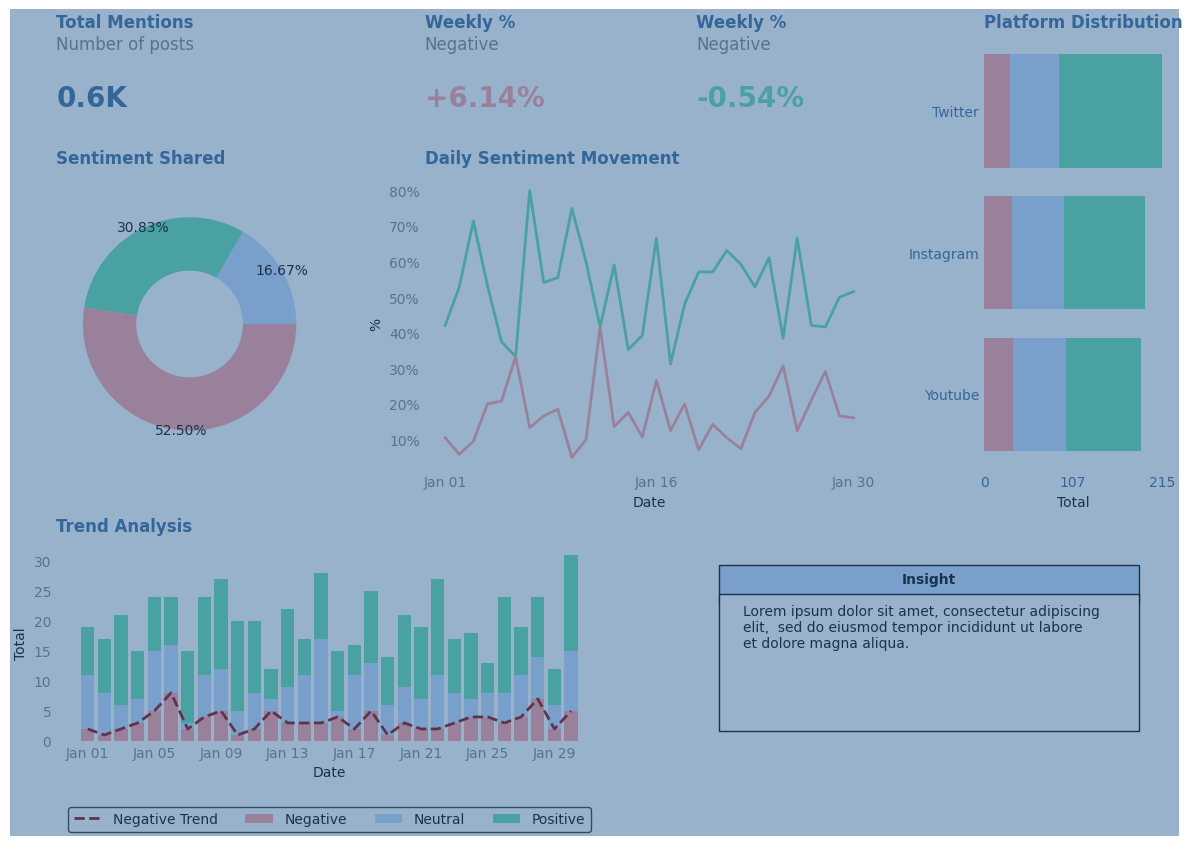

In [731]:
# TODO: generate with GenAI
insight_text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit, 
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. 
"""

insight_section(axs["8"], insight_text)

clear_output(wait=True)
display(master_fig)

# Build Report

In [ ]:
def header(canvas, doc, content):
    canvas.saveState()
    
    page_width, page_height = doc.pagesize
    
    w, h = content.wrap(page_width, doc.topMargin)
    content.drawOn(canvas, 0, page_height - h)
    canvas.restoreState()

def footer(canvas, doc, content):
    canvas.saveState()
    w, h = content.wrap(doc.width, doc.bottomMargin)
    content.drawOn(canvas, doc.leftMargin, h)
    canvas.restoreState()

def header_and_footer(canvas, doc, header_content, footer_content):
    header(canvas, doc, header_content)
    footer(canvas, doc, footer_content)
    
styles = getSampleStyleSheet()
    
#---------
logo_wheel_in = 0.5 * inch
logo_wheel = Image("./assets/Pertamina Digital Hub-Supergraphic_Primary.png", width=logo_wheel_in, height=logo_wheel_in)

title = Paragraph(
    "SOCIAL MEDIA SENTIMENT REPORT",
    ParagraphStyle(
		name="HeaderTitle",
		parent=styles["Normal"],
		fontName="Helvetica-Bold",
		fontSize=20,
		textColor=NAVY,
		spaceAfter=0
	)
)

logo_pertamina_width_in = 2.0 * inch
logo_pertamina_height_in = logo_wheel_in
logo_pertamina = Image("./assets/Pertamina Digital Hub_Logo-Primary_CMYK.png", width=logo_pertamina_width_in, height=logo_pertamina_height_in)

header_table = Table(
    [[logo_wheel, title, logo_pertamina]],
	colWidths=[
		logo_wheel_in,
		page_width - (logo_wheel_in + logo_pertamina_width_in),
		logo_pertamina_width_in
	]
)

header_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, -1), colors.HexColor(GRAY)),
    
    ("VALIGN", (0, 0), (-1, -1), "CENTER"),
    
    ("LEFTPADDING", (0, 0), (-1, -1), 0),
    ("RIGHTPADDING", (0, 0), (-1, -1), 0),
    
    ("TOPPADDING", (0, 0), (-1, -1), 15),
    ("BOTTOMPADDING", (0, 0), (-1, -1), 15),
]))

#---------
header_content = header_table
footer_content = Paragraph("This is a footer.", styles['Normal'])

frame = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height, id='normal')
template = PageTemplate(id='test', frames=frame, onPage=partial(header_and_footer, header_content=header_content, footer_content=footer_content))
doc.addPageTemplates([template])

In [733]:
def fig_to_img(fig, width=None):
    buffer = io.BytesIO()
    fig.savefig(buffer, format="png", dpi=300, bbox_inches="tight")
    buffer.seek(0)

    img = Image(buffer)

    # Optional: control width while preserving aspect ratio
    if width:
        img.drawWidth = width
        img.drawHeight = width * fig.get_figheight() / fig.get_figwidth()

    plt.close(fig)
    return img

In [734]:
elements = []

img = fig_to_img(master_fig, width=600)

elements.append(img)

doc.build(elements)